Github repo: https://github.com/tuengominh/imrl-hdqn.

# Libraries

In [ ]:
import os
import sys
import logging
import time
import copy
from collections import namedtuple, defaultdict
import pickle
import itertools
from itertools import count
import random
from random import randint
import math
import numpy as np
import pandas as pd
import matplotlib as plt
from matplotlib import pyplot
plt.style.use('ggplot')
%matplotlib inline

In [ ]:
# Gym
import gym
from gym.envs.registration import register
from gym import wrappers
from gym import spaces
from gym.utils import seeding

In [ ]:
# PyTorch
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd

# Environments

## FourRooms environment

A custom four rooms game environment as described in this [paper](http://www-anw.cs.umass.edu/~barto/courses/cs687/Sutton-Precup-Singh-AIJ99.pdf).

### Customize the environment

**References:** 
- https://github.com/p-christ/Deep-Reinforcement-Learning-Algorithms-with-PyTorch/blob/master/environments/Four_Rooms_Environment.py

**Modifications:**
- Remove unused attributes 
- More functions to get extra info from the environment

In [ ]:
class Four_Rooms_Env(gym.Env):
  def __init__(self, width=15, height=15, 
               random_start_user_loc=True,
               random_goal_loc=True):
  
    self.grid_width = width
    self.grid_height = height
    self.random_start_user_loc = random_start_user_loc
    self.random_goal_loc = random_goal_loc

    self.blank_space = "    "
    self.wall_space = "WALL"
    self.user_space = "USER"
    self.goal_space = "GOAL"

    self.actions = set(range(4))
    self.action_space = spaces.Discrete(4)
    self.action_opts = {0: "Up", 1: "Right", 2: "Down", 3: "Left"}

    self.current_user_loc = None
    self.current_goal_loc = None
    self.num_possible_states = self.grid_height * self.grid_width
    self.positive_reward = (self.grid_width + self.grid_height) * 3.0 # for achieving goal
    self.negative_reward = -1.0 # for not achieving goal
    self.reward_threshold = 0.0
    self.cummulative_reward = 0.0
    self.max_episode_steps = self.positive_reward

    if self.random_goal_loc:
      self.observation_space = spaces.Dict(dict(
        desired_goal=spaces.Box(0, self.num_possible_states, shape=(1,), dtype='float32'),
        achieved_goal=spaces.Box(0, self.num_possible_states, shape=(1,), dtype='float32'),
        observation=spaces.Box(0, self.num_possible_states, shape=(1,), dtype='float32'),
      ))
    else:
      self.observation_space = spaces.Discrete(self.num_possible_states)

  def create_grid(self):
    grid = [[self.blank_space for _ in range(self.grid_width)] for _ in range(self.grid_height)]
    
    centre_col = int(self.grid_width / 2)
    centre_row = int(self.grid_height / 2)
    gaps = [(centre_row, int(centre_col / 2) - 1),  
            (centre_row, centre_col + int(centre_col / 2)),
            (int(centre_row / 2), centre_col),
            (centre_row + int(centre_row / 2) + 1, centre_col)]
    
    for row in range(self.grid_height):
      for col in range(self.grid_width):
        if row == 0 or col == 0 or row == self.grid_height - 1 or col == self.grid_width - 1:
          grid[row][col] = self.wall_space
        if row == centre_row or col == centre_col:
          grid[row][col] = self.wall_space
        if (row , col) in gaps:
          grid[row][col] = self.blank_space
    
    return grid

  def reset(self):
    self.grid = self.create_grid()
    self.place_goal()
    self.place_agent()

    self.desired_goal = [self.location_to_state(self.current_goal_loc)]
    self.achieved_goal = [self.location_to_state(self.current_user_loc)]
    self.step_count = 0
    
    self.state = [self.location_to_state(self.current_user_loc), self.location_to_state(self.current_goal_loc)]
    self.next_state = None
    self.reward = 0
    self.done = False
    self.achieved_goal = self.state[:1]

    if self.random_goal_loc:
      self.s = {"observation": np.array(self.state[:1]),
                "desired_goal": np.array(self.desired_goal),
                "achieved_goal": np.array(self.achieved_goal)}
    else:
      self.s = np.array(self.state[:1])

    return self.s

  def step(self, action):
    if type(action) is np.ndarray:
      assert action.shape[0] == 1
      assert len(action.shape) == 1
      action = action[0]

    self.step_count += 1
    #self.print_action(action)
    new_state = self.calculate_new_state(action)

    if not self.is_wall(new_state):
      self.move_user(self.current_user_loc, new_state)
    
    self.next_state = [self.location_to_state(self.current_user_loc), self.desired_goal[0]]

    if self.goal_colocation():
      #print("Co-located with goal!")
      self.reward = self.positive_reward
      self.cummulative_reward += self.reward
      self.done = True
    else:
      self.reward = self.negative_reward
      self.cummulative_reward += self.reward
      if self.step_count >= self.max_episode_steps: 
        self.done = True
      else: 
        self.done = False
    self.achieved_goal = self.next_state[:1]
    self.state = self.next_state

    if self.random_goal_loc:
      self.s = {"observation": np.array(self.next_state[:1]),
                "desired_goal": np.array(self.desired_goal),
                "achieved_goal": np.array(self.achieved_goal)}
    else:
      self.s = np.array(self.next_state[:1])

    #print(self.s)
    #print("Step reward:", self.reward)
    #print("Cummulative reward:", self.cummulative_reward)
    #print("Done:", self.done)
    #self.visualize()
    return self.s, self.reward, self.done, {}

  # Map a (x, y) location to an number that represents its position
  def location_to_state(self, location):
    return location[0] + location[1] * self.grid_height

  # Map a state number to the (x, y) grid point 
  def state_to_location(self, state):
    col = int(state / self.grid_height)
    row = state - col * self.grid_height
    return (row, col)

  def random_place(self, obj, invalid_places):
    placed = False
    while not placed:
      random_row = randint(0, self.grid_height - 1)
      random_col = randint(0, self.grid_width - 1)

      if self.grid[random_row][random_col] not in invalid_places:
        self.grid[random_row][random_col] = obj
        placed = True

    return (random_row, random_col)
  
  def place_goal(self):
    if self.random_goal_loc:
      self.current_goal_loc = self.random_place(self.goal_space, [self.wall_space, self.user_space])
    else:
      self.current_goal_loc = (3, 3)
      self.grid[3][3] = self.goal_space
  
  def place_agent(self):
    if self.random_start_user_loc:
      self.current_user_loc = self.random_place(self.user_space, [self.wall_space, self.goal_space])
    else:
      self.current_user_loc = (1, 1)
      self.grid[1][1] = self.user_space
  
  def print_action(self, action):
    if action == 0:
      print("Action picked: Up")
    elif action == 1:
      print("Action picked: Right")
    elif action == 2:
      print("Action picked: Down")
    elif action == 3:
      print("Action picked: Left")

  def calculate_new_state(self, action):
    if action == 0:
      new_state = (self.current_user_loc[0] - 1, self.current_user_loc[1])
    elif action == 1:
      new_state = (self.current_user_loc[0], self.current_user_loc[1] + 1)
    elif action == 2:
      new_state = (self.current_user_loc[0] + 1, self.current_user_loc[1])
    elif action == 3:
      new_state = (self.current_user_loc[0], self.current_user_loc[1] - 1)
    else:
      raise ValueError("Action must be 0, 1, 2, or 3")
    return new_state

  def is_wall(self, location):
    return self.grid[location[0]][location[1]] == "WALL"
  
  def goal_colocation(self):
    return self.current_user_loc == self.current_goal_loc

  def move_user(self, current_location, new_location):
    assert self.grid[current_location[0]][current_location[1]] == self.user_space, "{} vs. {}".format(self.grid[current_location[0]][current_location[1]], self.user_space)
    self.grid[new_location[0]][new_location[1]] = self.user_space
    self.grid[current_location[0]][current_location[1]] = self.blank_space
    self.current_user_loc = (new_location[0], new_location[1])

  def move_goal(self, current_location, new_location):
    assert self.grid[current_location[0]][current_location[1]] == self.goal_space
    self.grid[new_location[0]][new_location[1]] = self.goal_space
    self.grid[current_location[0]][current_location[1]] = self.blank_space
    self.current_goal_loc = (new_location[0], new_location[1])

  def calculate_reward(self, achieved_goal, desired_goal, info):
    if (achieved_goal == desired_goal).all():
      reward = self.positive_reward
    else:
      reward = self.negative_reward
    return reward

  def render(self):
    for row in range(len(self.grid)):
      print(self.grid[row])

  # Visualize the current grid with matplotlib 
  def visualize(self):
    copied_grid = copy.deepcopy(self.grid)
    for row in range(self.grid_height):
      for col in range(self.grid_width):
        if copied_grid[row][col] == self.wall_space:
          copied_grid[row][col] = -100
        elif copied_grid[row][col] == self.blank_space:
          copied_grid[row][col] = 0
        elif copied_grid[row][col] == self.user_space:
          copied_grid[row][col] = 10
        elif copied_grid[row][col] == self.goal_space:
          copied_grid[row][col] = 20
        else:
          raise ValueError("Invalid value.")
    copied_grid = np.array(copied_grid)
    cmap = plt.colors.ListedColormap(["black", "white", "blue", "red"])
    bounds = [-101, -1, 1, 11, 21]
    norm = plt.colors.BoundaryNorm(bounds, cmap.N)
    pyplot.imshow(copied_grid, interpolation='nearest', cmap=cmap, norm=norm)
    print("Black = Wall, White = Empty, Blue = User, Red = Goal")
    pyplot.show()

### Test the environment
Run this to get visualizations only after running experiments to prevent conflicts.

In [ ]:
env_4r = Four_Rooms_Env()
env_4r.reset()

{'achieved_goal': array([188]),
 'desired_goal': array([124]),
 'observation': array([188])}

In [ ]:
env_4r.observation_space

Dict(achieved_goal:Box(0.0, 225.0, (1,), float32), desired_goal:Box(0.0, 225.0, (1,), float32), observation:Box(0.0, 225.0, (1,), float32))

In [ ]:
env_4r.action_space

Discrete(4)

In [ ]:
done = False
while not done:
    a = env_4r.action_space.sample()
    obs, reward, done, _ = env_4r.step(a)

Black = Wall, White = Empty, Blue = User, Red = Goal


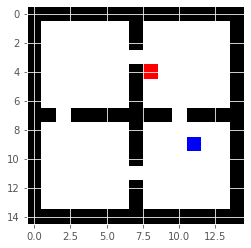

In [ ]:
env_4r.visualize()

In [ ]:
obs_arr = np.array([[key,val] for (key,val) in obs.items()])
fr_input_shape = obs_arr.shape
fr_nactions = env_4r.action_space.n
print(fr_input_shape)
print(fr_nactions)

(3, 2)
4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


## CraftingWorld environment

A custom crafting environment described in this [paper](https://papers.nips.cc/paper/2019/file/00989c20ff1386dc386d8124ebcba1a5-Paper.pdf). The base environment can be imported via a pip [package]((https://gym-craftingworld.readthedocs.io/en/latest/envs/gen_info.html#)), arguments can be easily customized and the new environment can be easily registered.

### Customize the environment

Create a custom sparse environment by limiting the tasks that can grant extrinsic rewards.

In [ ]:
!pip install gym-craftingworld
import gym_craftingworld

**List of objects:**
- *sticks:* pickable
- *axe:* pickable
- *hammer:* pickable
- *rock:* blocking
- *tree:* blocking
- *bread*
- *house*
- *wheat*

**List of tasks:**
- *MoveAxe:* successfully pick up and drop axe
- *MoveHammer:* successfully pick up and drop hammer
- *MoveSticks:* successfully pick up and drop sticks
- *ChopRock:* pick up a hammer and destroys the rock
- *MakeBread:* brings the axe to the wheat which transforms it into bread
- *ChopTree:* pick up the axe and bring it to the tree, which transforms the tree into logs (sticks)
- *BuildHouse:* pick up the hammer and brings it to logs (sticks) to transform them into a house
- *EatBread:* eat bread if it lands on a state that contains bread
- *GoToHouse:* go to house if it lands on a state that contains house

In [ ]:
# Customize a sparse environment
register(id='craftingworldSparseEnv-v0',
         entry_point='gym_craftingworld.envs:CraftingWorldEnv',
         kwargs={# size of the grid world
                 'size' : (10, 10),
                 # maximum steps per episode
                 'max_steps': 100,
                 # a fixed list of tasks for the agent to achieve
                 'fixed_goal' : ['MakeBread','BuildHouse','EatBread','GoToHouse'], 
                 # a list of tasks to ignore when calculating reward
                 'tasks_to_ignore' : ['ChopTree','ChopRock','MoveAxe','MoveHammer','MoveSticks']
                }
         )

### Test the environment

Run this to get visualizations only after running experiments to prevent conflicts.

In [ ]:
env_craft = gym.make('craftingworldSparseEnv-v0')

In [ ]:
# Only include the fixed goals
env_craft.task_list

['MakeBread', 'EatBread', 'BuildHouse', 'GoToHouse']

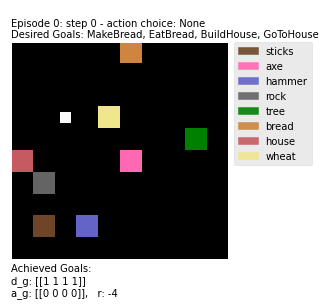

In [ ]:
# Store .gif
env_craft.allow_gif_storage()
# Reset environment and render .gif within notebook
env_craft.reset()

In [ ]:
env_craft.observation_space

Dict(achieved_goal:Box(0, 1, (1, 4), int64), desired_goal:Box(0, 1, (1, 4), int64), observation:Box(0, 1, (10, 10, 12), int64))

In [ ]:
env_craft.action_space

Discrete(6)

**List of actions:**
- *up* = 0
- *right* = 1
- *down* = 2
- *left* = 3
- *pickup* = 4
- *drop* = 5

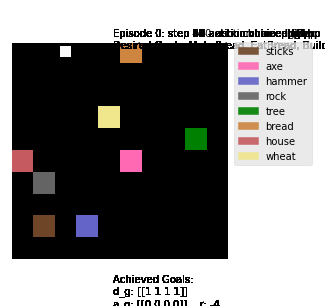

In [ ]:
done = False
while not done:
    a = env_craft.action_space.sample()
    obs, extrinsic_reward, done, info = env_craft.step(a)

In [ ]:
obs_arr = np.array([[key,val] for (key,val) in obs.items()])
crafting_input_shape = obs_arr.shape
crafting_nactions = env_craft.action_space.n
print(crafting_input_shape)
print(crafting_nactions)

(3, 2)
6


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


### Extra functions

More functions to get extra info from the environment.

In [ ]:
OBJECTS = ['sticks','axe','hammer','rock','tree','bread','house','wheat']
TASK_LIST = ['MakeBread','EatBread','BuildHouse','ChopTree','ChopRock','GoToHouse','MoveAxe','MoveHammer','MoveSticks']

In [ ]:
# Functions to get a list of achieved/not achieved task
def check_tasks(env, achieved):
  results = []
  for task, done in env.eval_tasks().items():  
    if done == achieved:
      results.append(task)
  return results

In [ ]:
# Return the tasks done at a certain observation
def check_tasks_done(env, obs):
  done_tasks = []
  for item in check_tasks(env, 1):
    if item == 'MakeBread':
      done_tasks.append(0)
    elif item == 'EatBread':
      done_tasks.append(1)
    elif item == 'BuildHouse':
      done_tasks.append(2)
    elif item == 'ChopTree':
      done_tasks.append(3)
    elif item == 'ChopRock':
      done_tasks.append(4)
    elif item == 'GoToHouse':
      done_tasks.append(5)
    elif item == 'MoveAxe':
      done_tasks.append(6)
    elif item == 'MoveHammer':
      done_tasks.append(7)
    elif item == 'MoveSticks':
      done_tasks.append(8)
  return done_tasks

In [ ]:
def convert_obj_loc(env, obs_arr, i):
  obj_loc = np.array(env.get_objects(i, obs_arr[0, 1]))
  if obj_loc.size != 0:
    obj_loc = obj_loc[0]
  else:
    obj_loc = [0,0]
  return obj_loc[0], obj_loc[1]

In [ ]:
# Return the type of object colocated with user
def check_colocated_objects(env, obs):
  obs_arr = np.array([[key,val] for (key,val) in obs.items()])
  row = env.agent_pos.row
  col = env.agent_pos.col
  obj_ids = []
  for i in range(7):
    obj_row, obj_col = convert_obj_loc(env, obs_arr, i)
    if obj_row == row and obj_col == env.agent_pos.col:
      obj_ids.append(i)
  return obj_ids

# Agents 

**References:** 
- As described in this [paper](https://arxiv.org/pdf/1604.06057.pdf).
- https://github.com/higgsfield/RL-Adventure
- https://github.com/skumar9876/Hierarchical-DQN/blob/master/hierarchical_dqn.py

**Modifications:** 
- Re-write the learning algos to make them work with the high-dimensional, non-numerical obs space of custom envs
- Define proper states and/or subgoals of custom environments 
- Modify the construction of the h-DQN agent
- Implement data loggings and add more visual plots
- Add comments for re-used components (utils and NN)

## Q-learning

### Epsilon-Greedy policy

Epsilon-Greedy is a simple method to balance exploration and exploitation by choosing between exploration and exploitation randomly. The epsilon-greedy, where epsilon refers to the probability of choosing to explore, exploits most of the time with a small chance of exploring.

In [ ]:
# Return a function that takes a state and returns the probabilities for each action as an array
def epsilon_greedy_policy(Q, epsilon, num_actions):
  def policy_fn(state):
    probs = (epsilon / num_actions) * np.ones(num_actions) # 1 / epsilon for non-greedy actions
    greedy_action = Q[state].argmax()
    probs[greedy_action] += 1.0 - epsilon # (1 / epsilon + (1 - epsilon)) for greedy action
    return probs
  return policy_fn

In [ ]:
# Schedule for probability of chosing random action
class ExplorationSchedule(object):
  def __init__(self, schedule_timesteps, final_p, initial_p=1.0):
    self.schedule_timesteps = schedule_timesteps
    self.final_p = final_p
    self.initial_p = initial_p

  def value(self, t):
    fraction  = min(float(t) / self.schedule_timesteps, 1.0)
    return self.initial_p + fraction * (self.final_p - self.initial_p)

### Q-learning algorithm

In [ ]:
EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards", "episode_in_rewards"])

In [ ]:
# Return a tuple including optimal Q (dict of action-value), stats (EpisodeStats object), visits (2D array), tasks (2D array)
def q_learning(env_name, num_episodes, 
               discount_factor=0.99, lr=0.00025, 
               exploration_schedule=ExplorationSchedule(50000, 0.1, 1.0)):
  
  n_hundred_episode = int(np.floor(num_episodes / 100)) 
  total_timestep = 0
  
  if env_name == 'FourRooms':
    env = Four_Rooms_Env()
    # State = location on grid
    visits = np.zeros((n_hundred_episode, env.num_possible_states))
    tasks = np.zeros((n_hundred_episode, 0))
  elif env_name == 'CraftingWorld':
    env = gym.make('craftingworldSparseEnv-v0')
    # State = type of co-located object 
    visits = np.zeros((n_hundred_episode, 9))
    tasks = np.zeros((n_hundred_episode, 9))

  # Keep track of useful statistics
  stats = EpisodeStats(episode_lengths=np.zeros(num_episodes),
                       episode_rewards=np.zeros(num_episodes),
                       episode_in_rewards=np.zeros(num_episodes))
  
  # A nested dictionary that maps state -> (action -> action-value)
  Q = defaultdict(lambda: np.zeros(env.action_space.n))

  for i_hundred_episode in range(n_hundred_episode):
    for i_episode in range(100): 
      if env_name == 'FourRooms':
        env.reset()
        current_state = env.location_to_state(env.current_user_loc)
        visits[i_hundred_episode][current_state] += 1
      elif env_name == 'CraftingWorld':
        env.reset()
        # Remember to minus col (y) value by 1 to get the starting agent_pos
        # Actually, not that important, only for plotting
        obs, _, _, _ = env.step(0)

        current_states = check_colocated_objects(env, obs)
        if len(current_states) > 0:
          current_state = current_states[0]
          for s in current_states:
            visits[i_hundred_episode][s] += 1
        else:
          visits[i_hundred_episode][8] += 1
          current_state = 8 

        current_tasks = check_tasks_done(env, obs)
        if len(current_tasks) > 0:
          for g in current_tasks:
            tasks[i_hundred_episode][g] += 1

      for t in itertools.count():
        # Keep track number of time-step per episode only for plotting
        total_timestep += 1
        # Get epislon from exploration schedule
        epsilon = exploration_schedule.value(total_timestep)
        # Improve epsilon greedy policy using latest updated Q
        policy = epsilon_greedy_policy(Q, epsilon, env.action_space.n)

        # Choose the action based on epsilon greedy policy
        action_probs = policy(current_state)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        
        # Step the environment
        if env_name == 'FourRooms':
          obs, reward, done, _ = env.step(action) 
          next_state = env.location_to_state(env.current_user_loc)
          visits[i_hundred_episode][next_state] += 1
        elif env_name == 'CraftingWorld':
          obs, reward, done, _ = env.step(action) 

          next_states = check_colocated_objects(env, obs)
          if len(next_states) > 0:
            next_state = next_states[0]
            for s in next_states:
              visits[i_hundred_episode][s] += 1
          else:
            visits[i_hundred_episode][8] += 1
            next_state = 8 

          next_tasks = check_tasks_done(env, obs)
          if len(next_tasks) > 0:
            for g in next_tasks:
              tasks[i_hundred_episode][g] += 1

        # Evaluate Q using estimated action value of (next_state, greedy_next_action)
        greedy_next_action = Q[next_state].argmax()
        td_target = reward + discount_factor * Q[next_state][greedy_next_action]
        td_error = td_target - Q[current_state][action]
        Q[current_state][action] += lr * td_error

        # Update statistics
        stats.episode_rewards[i_hundred_episode*100 + i_episode] += reward 
        stats.episode_lengths[i_hundred_episode*100 + i_episode] = t 

        if done:
          break
        else:
          current_state = next_state

  return Q, stats, visits, tasks

## h-DQN

### Replay buffer

Used to store trajectories of experience when executing a policy in an environment. 

In [ ]:
Transition = namedtuple('Transition',('state', 'action', 'next_state', 'reward', 'done'))

In [ ]:
class ReplayBuffer(object):
  def __init__(self, capacity):
    self.capacity = capacity
    self.memory = []
    self.position = 0

  def store_transition(self, *args):
    if len(self.memory) < self.capacity:
      self.memory.append(None)
    self.memory[self.position] = Transition(*args)
    self.position = (self.position + 1) % self.capacity

  def sample(self, batch_size):
    state_batch, goal_batch, next_state_batch, ex_reward_batch, done_mask = zip(*random.sample(self.memory, batch_size))
    state_batch = np.concatenate(state_batch, axis=0)
    goal_batch = np.array(goal_batch)
    next_state_batch = np.concatenate(next_state_batch, axis=0)
    ex_reward_batch = np.array(ex_reward_batch)
    done_mask = np.array(done_mask)
    return state_batch, goal_batch, next_state_batch, ex_reward_batch, done_mask

  def __len__(self):
    return len(self.memory)

### Construct the controller and meta-controller

The meta-controller takes state as argument and output value for every state-goal pair, while the controller takes each of those pairs as argument and output value for every (state, goal)-action pair.

- *in_features:* number of features of input e.g. number of possible subgoals for the meta-controller or number of possible primitive actions for the controller
- *out_features:* number of features of output e.g. desired subgoal for meta-controller or desired primitive action for controller

In [ ]:
# Take state and output value for every state-goal pair
class MetaController(nn.Module):
  def __init__(self, env_name):
    super(MetaController, self).__init__()

    if env_name == 'FourRooms':
      self.in_features = 225 
      self.out_features = 225
    elif env_name == 'CraftingWorld':
      self.in_features = 9 
      self.out_features = 9

    self.fc1 = nn.Linear(self.in_features, 256)
    self.fc2 = nn.Linear(256, self.out_features)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    return self.fc2(x)

In [ ]:
# Take (state, goal) and output value for every (state, goal)-action pair
class Controller(nn.Module):
  def __init__(self, env_name):
    super(Controller, self).__init__()
    
    if env_name == 'FourRooms':
      self.in_features = 450 # env.num_possible_states * 2
      self.out_features = 4
    elif env_name == 'CraftingWorld':
      self.in_features = 18
      self.out_features = 6

    self.fc1 = nn.Linear(self.in_features, 256)
    self.fc2 = nn.Linear(256, self.out_features)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    return self.fc2(x)

### Construct the base agent

In [ ]:
OptimizerSpec = namedtuple("OptimizerSpec", ["constructor", "kwargs"])

In [ ]:
USE_CUDA = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if USE_CUDA else torch.FloatTensor

Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

In [ ]:
class hDQN():
  # Build model
  def __init__(self, env_name,
              optimizer_spec,
              num_goal=0, 
              num_action=0, 
              replay_memory_size=10000,
              batch_size=32): 
    
    if env_name == 'FourRooms':
      # The number of goal that agent can choose from
      self.num_goal = 225 #env.num_possible_states
      # The number of action that agent can choose from
      self.num_action = 4
    elif env_name == 'CraftingWorld':
      self.num_goal = 9
      self.num_action = 6

    # How many transitions to sample each time experience is replayed
    self.batch_size = batch_size

    # Construct meta-controller and controller
    self.meta_controller = MetaController(env_name).type(dtype) 
    self.target_meta_controller = MetaController(env_name).type(dtype) 
    self.controller = Controller(env_name).type(dtype) 
    self.target_controller = Controller(env_name).type(dtype) 

    # Construct the optimizers for meta-controller and controller
    self.meta_optimizer = optimizer_spec.constructor(self.meta_controller.parameters(), **optimizer_spec.kwargs)
    self.ctrl_optimizer = optimizer_spec.constructor(self.controller.parameters(), **optimizer_spec.kwargs)
    
    # Construct the replay memory for meta-controller and controller
    self.meta_replay_memory = ReplayBuffer(replay_memory_size)
    self.ctrl_replay_memory = ReplayBuffer(replay_memory_size)

  # Calculate intrinsic reward
  def get_intrinsic_reward(self, env_name, goal, state):
    if env_name == 'FourRooms':
      return 10.0 if goal == state else 0.0
    elif env_name == 'CraftingWorld':
      return 40.0 if goal == state else 0.0  

  def select_goal(self, state, epsilon):
    sample = random.random()
    if sample > epsilon:
      state = torch.from_numpy(state).type(dtype)
      with torch.no_grad():
        res = self.meta_controller(Variable(state)).data.max(1)[1].cpu()
      return res
    else:
      return torch.IntTensor([random.randrange(self.num_goal)])

  def select_action(self, joint_state_goal, epilson):
    sample = random.random()
    if sample > epilson:
      joint_state_goal = torch.from_numpy(joint_state_goal).type(dtype)
      with torch.no_grad():
        res = self.controller(Variable(joint_state_goal)).data.max(1)[1].cpu()
      return res
    else:
      return torch.IntTensor([random.randrange(self.num_action)])

  def update_meta_controller(self, gamma=1.0):
    if len(self.meta_replay_memory) < self.batch_size:
      return

    state_batch, goal_batch, next_state_batch, ex_reward_batch, done_mask = \
      self.meta_replay_memory.sample(self.batch_size)
    state_batch = Variable(torch.from_numpy(state_batch).type(dtype))
    goal_batch = Variable(torch.from_numpy(goal_batch).long())
    next_state_batch = Variable(torch.from_numpy(next_state_batch).type(dtype))
    ex_reward_batch = Variable(torch.from_numpy(ex_reward_batch).type(dtype))
    not_done_mask = Variable(torch.from_numpy(1 - done_mask)).type(dtype)
    
    if USE_CUDA:
      goal_batch = goal_batch.cuda()

    # Compute current Q value and choose Q based on subgoal chosen
    current_Q_values = self.meta_controller(state_batch).gather(1, goal_batch.unsqueeze(1))

    # Compute next Q value based on which subgoal gives max Q values and detach variable from the current graph 
    next_max_q = self.target_meta_controller(next_state_batch).detach().max(1)[0]
    next_Q_values = not_done_mask * next_max_q

    # Compute the target of the current Q values
    target_Q_values = ex_reward_batch + (gamma * next_Q_values)
    # Compute Bellman error (using Huber loss)
    loss = F.smooth_l1_loss(current_Q_values, target_Q_values)

    # Copy Q to target Q before updating parameters of Q
    self.target_meta_controller.load_state_dict(self.meta_controller.state_dict())
    
    # Optimize the model
    self.meta_optimizer.zero_grad()
    loss.backward()
    for param in self.meta_controller.parameters():
      param.grad.data.clamp_(-1, 1)
    self.meta_optimizer.step()

  def update_controller(self, gamma=1.0):
    if len(self.ctrl_replay_memory) < self.batch_size:
      return

    state_goal_batch, action_batch, next_state_goal_batch, in_reward_batch, done_mask = \
      self.ctrl_replay_memory.sample(self.batch_size)
    state_goal_batch = Variable(torch.from_numpy(state_goal_batch).type(dtype))
    action_batch = Variable(torch.from_numpy(action_batch).long())
    next_state_goal_batch = Variable(torch.from_numpy(next_state_goal_batch).type(dtype))
    in_reward_batch = Variable(torch.from_numpy(in_reward_batch).type(dtype))
    not_done_mask = Variable(torch.from_numpy(1 - done_mask)).type(dtype)
    
    if USE_CUDA:
      action_batch = action_batch.cuda()

    # Compute current Q value and choose Q based on primitive action taken
    current_Q_values = self.controller(state_goal_batch).gather(1, action_batch.unsqueeze(1))

    # Compute next Q value based on which action gives max Q values and detach variable from the current graph 
    next_max_q = self.target_controller(next_state_goal_batch).detach().max(1)[0]
    next_Q_values = not_done_mask * next_max_q

    # Compute the target of the current Q values
    target_Q_values = in_reward_batch + (gamma * next_Q_values)
    # Compute Bellman error (using Huber loss)
    loss = F.smooth_l1_loss(current_Q_values, target_Q_values)

    # Copy Q to target Q before updating parameters of Q
    self.target_controller.load_state_dict(self.controller.state_dict())

    # Optimize the model
    self.ctrl_optimizer.zero_grad()
    loss.backward()
    for param in self.controller.parameters():
      param.grad.data.clamp_(-1, 1)
    self.ctrl_optimizer.step()

### h-DQN algorithm

In [ ]:
def one_hot_state(state, size):
    vector = np.zeros(size)
    vector[state] = 1.0
    return np.expand_dims(vector, axis=0)

def one_hot_goal(goal, size):
    vector = np.zeros(size)
    vector[goal] = 1.0
    return np.expand_dims(vector, axis=0)

In [ ]:
# Return a trained h-DQN agent consists of a meta-controller and a controller, stats (EpisodeStats object), visits (2D array), tasks (2D array)
def hdqn_learning(env_name, agent, num_episodes,
                  exploration_schedule=ExplorationSchedule(50000, 0.1, 1.0),
                  gamma=0.99):

  n_hundred_episode = int(np.floor(num_episodes / 100))
  total_timestep = 0
  meta_timestep = 0
  ctrl_timestep = defaultdict(int) #store time step for each subgoal

  if env_name == 'FourRooms':
    env = Four_Rooms_Env()
    # State = location on grid
    visits = np.zeros((n_hundred_episode, env.num_possible_states))
    tasks = np.zeros((n_hundred_episode, 0))
  elif env_name == 'CraftingWorld':
    env = gym.make('craftingworldSparseEnv-v0')
    # State = type of co-located object 
    visits = np.zeros((n_hundred_episode, 9))
    tasks = np.zeros((n_hundred_episode, 9))

  # Keep track of useful statistics
  stats = EpisodeStats(episode_lengths=np.zeros(num_episodes),
                       episode_rewards=np.zeros(num_episodes),
                       episode_in_rewards=np.zeros(num_episodes),)

  for i_hundred_episode in range(n_hundred_episode):
    for i_episode in range(100):
      episode_length = 0

      if env_name == 'FourRooms':
        env.reset()
        current_state = env.location_to_state(env.current_user_loc)
        visits[i_hundred_episode][current_state] += 1
        encoded_current_state = one_hot_state(current_state, env.num_possible_states)

      elif env_name == 'CraftingWorld':
        env.reset()
        obs, _, _, _ = env.step(0)

        current_states = check_colocated_objects(env, obs)
        if len(current_states) > 0:
          current_state = current_states[0]
          for s in current_states:
            visits[i_hundred_episode][s] += 1
        else:
          visits[i_hundred_episode][8] += 1
          current_state = 8 

        current_tasks = check_tasks_done(env, obs)
        if len(current_tasks) > 0:
          for g in current_tasks:
            tasks[i_hundred_episode][g] += 1

        encoded_current_state = one_hot_state(current_state, 9)

      done = False
      while not done:
        meta_timestep += 1

        # Get meta epsilon from exploration_schedule
        meta_epsilon = exploration_schedule.value(total_timestep)

        if env_name == 'FourRooms':
          # Select greedy subgoal (expected grid location) from meta state 
          subgoal = agent.select_goal(encoded_current_state, meta_epsilon)[0]
          encoded_goal = one_hot_goal(subgoal,env.num_possible_states)
        elif env_name == 'CraftingWorld':
          # Select greedy subgoal (expected object co-located) from meta state 
          subgoal = agent.select_goal(encoded_current_state, meta_epsilon)[0]
          subgoal2 = torch.clamp(subgoal, min=0, max=8)
          encoded_goal = one_hot_goal(subgoal2, 9)

        meta_extrinsic_reward = 0 # The total extrinsic reward of each episode

        subgoal_reached = False
        while not done and not subgoal_reached:
          total_timestep += 1
          episode_length += 1
          ctrl_timestep[subgoal] += 1

          # Get epsilon from exploration_schedule
          ctrl_epsilon = exploration_schedule.value(total_timestep)
          # Select greedy primitive action from state-goal pair 
          state_subgoal_pair = np.concatenate([encoded_current_state, encoded_goal], axis=1)
          action = agent.select_action(state_subgoal_pair, ctrl_epsilon)[0]

          # Step the environment 
          if env_name == 'FourRooms':
            obs, extrinsic_reward, done, _ = env.step(action) 
            next_state = env.location_to_state(env.current_user_loc)
            visits[i_hundred_episode][next_state] += 1
            encoded_next_state = one_hot_state(next_state, env.num_possible_states)

          elif env_name == 'CraftingWorld':
            obs, extrinsic_reward, done, _ = env.step(action) 

            next_states = check_colocated_objects(env, obs)
            if len(next_states) > 0:
              next_state = next_states[0]
              for s in next_states:
                visits[i_hundred_episode][s] += 1
            else:
              visits[i_hundred_episode][8] += 1
              next_state = 8 

            next_tasks = check_tasks_done(env, obs)
            if len(next_tasks) > 0:
              for g in next_tasks:
                tasks[i_hundred_episode][g] += 1
            
            encoded_next_state = one_hot_state(next_state, 9)

          # Calculate intrinsic reward
          intrinsic_reward = agent.get_intrinsic_reward(env_name, subgoal, next_state)
          # Check if the goal is reached after stepping the environment
          subgoal_reached = next_state == subgoal
          
          # Update statistics
          stats.episode_rewards[i_hundred_episode*100 + i_episode] += extrinsic_reward
          stats.episode_in_rewards[i_hundred_episode*100 + i_episode] += intrinsic_reward
          stats.episode_lengths[i_hundred_episode*100 + i_episode] = episode_length

          # Store the transition of the controller
          next_state_subgoal_pair = np.concatenate([encoded_next_state, encoded_goal], axis=1)
          # The state-goal pair is the intrinsic state of the controller 
          agent.ctrl_replay_memory.store_transition(state_subgoal_pair, action, next_state_subgoal_pair, intrinsic_reward, subgoal_reached)

          # Update both meta-controller and controller
          agent.update_meta_controller(gamma)
          agent.update_controller(gamma)
          meta_extrinsic_reward += extrinsic_reward
          current_state = next_state
          encoded_current_state = encoded_next_state

        # Store the transition of the meta-controller when a subgoal is reached
        agent.meta_replay_memory.store_transition(encoded_current_state, subgoal, encoded_next_state, meta_extrinsic_reward, done)

  return agent, stats, visits, tasks

# Experiments

## Plotting functions

In [ ]:
from matplotlib.pyplot import cm

In [ ]:
def plot_extrinsic_rewards(stats, smoothing_window=10, noshow=False):
  # Plot the episode reward over time
  fig = pyplot.figure(figsize=(20,10))
  rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
  pyplot.plot(rewards_smoothed)
  pyplot.xlabel("Episode")
  pyplot.ylabel("Episode Reward")
  pyplot.title("Episode Reward over Time")
  pyplot.show(fig)

In [ ]:
def plot_intrinsic_rewards(stats, smoothing_window=10, noshow=False):
  # Plot the episode intrinsic reward over time
  fig = pyplot.figure(figsize=(20,10))
  rewards_smoothed = pd.Series(stats.episode_in_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
  pyplot.plot(rewards_smoothed, c='blue')
  pyplot.xlabel("Episode")
  pyplot.ylabel("Episode Intrinsic Reward")
  pyplot.title("Episode Intrinsic Reward over Time")
  pyplot.show(fig)

In [ ]:
def plot_visited_states(visits, num_episodes):
  n_hundred_episode = int(np.floor(num_episodes / 100)) 
  eps = list(range(1, n_hundred_episode + 1))
  pyplot.figure(figsize=(20,10))

  #n_state = visits.shape[1]
  n_state = visits.shape[1] - 1 # ignore empty cell visited in case of Crafting World
  color=iter(cm.rainbow(np.linspace(0,1,n_state)))
  for i_state in range(n_state):
    state_label = "State %d" % (i_state + 1)
    c=next(color)
    pyplot.plot(eps, visits[:, i_state]/100, label=state_label, c=c) 

  pyplot.legend()
  pyplot.xlabel("Episodes (*100)")
  pyplot.title("Number of visits averaged over 100 episodes")
  pyplot.ylim (-0.1,8)
  pyplot.grid(True)

In [ ]:
def plot_tasks_done(tasks, num_episodes):
  n_hundred_episode = int(np.floor(num_episodes / 100)) 
  eps = list(range(1, n_hundred_episode + 1))
  pyplot.figure(figsize=(20,10))

  n_state = tasks.shape[1]
  color=iter(cm.rainbow(np.linspace(0,1,n_state)))
  for i_g in range(n_state):
    g_label = "Task %d" % (i_g + 1)
    c=next(color)
    pyplot.plot(eps, tasks[:, i_g]/100, label=g_label, c=c) 

  pyplot.legend()
  pyplot.xlabel("Episodes (*100)")
  pyplot.title("Number of tasks done averaged over 100 episodes")
  pyplot.ylim (-1,25)
  pyplot.grid(True)

## FourRooms Environment

### Q-learning

In [ ]:
NUM_EPISODES = 1000
Q, stats, visits, tasks = q_learning('FourRooms', NUM_EPISODES, lr=0.00025, exploration_schedule=ExplorationSchedule(50000, 0.1, 1.0))

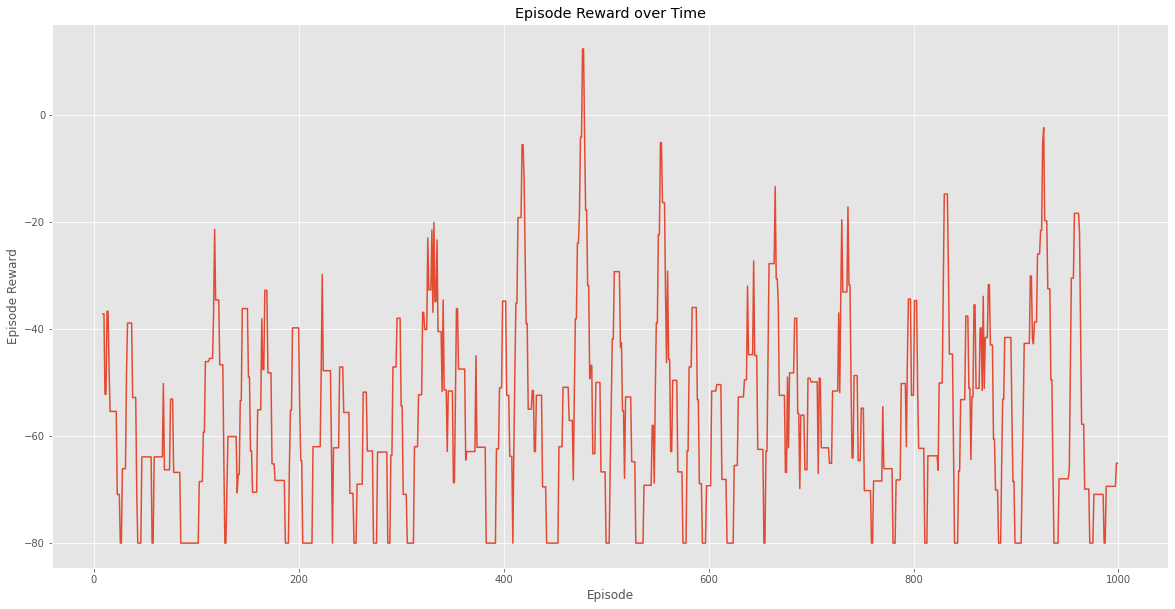

In [ ]:
plot_extrinsic_rewards(stats)

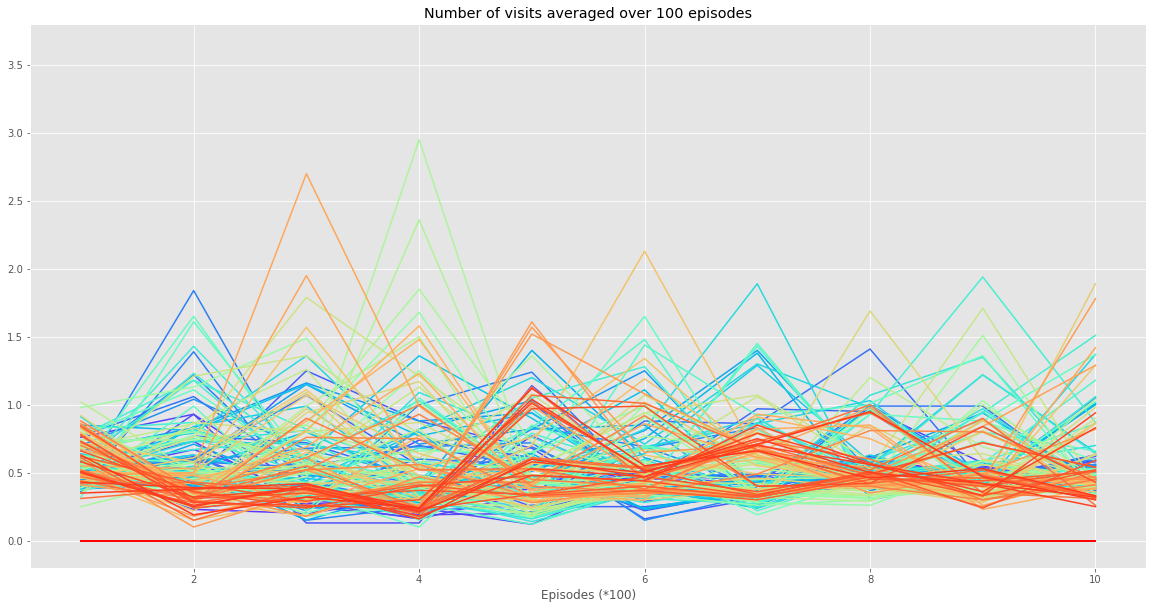

In [ ]:
plot_visited_states(visits, NUM_EPISODES)

### h-DQN

In [ ]:
NUM_EPISODES = 1000
BATCH_SIZE = 16
GAMMA = 1.0
REPLAY_MEMORY_SIZE = 10000
LEARNING_RATE = 0.00025
ALPHA = 0.95
EPS = 0.01

optimizer_spec = OptimizerSpec(
  constructor=optim.RMSprop,
  kwargs=dict(lr=LEARNING_RATE, alpha=ALPHA, eps=EPS)
)

agent = hDQN(
  env_name='FourRooms',
  optimizer_spec=optimizer_spec,
  replay_memory_size=REPLAY_MEMORY_SIZE,
  batch_size=BATCH_SIZE
)

In [ ]:
agent, stats2, visits2, tasks2 = hdqn_learning(
  env_name='FourRooms',
  agent=agent,
  num_episodes=NUM_EPISODES,
  exploration_schedule=ExplorationSchedule(50000, 0.1, 1),
  gamma=GAMMA
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


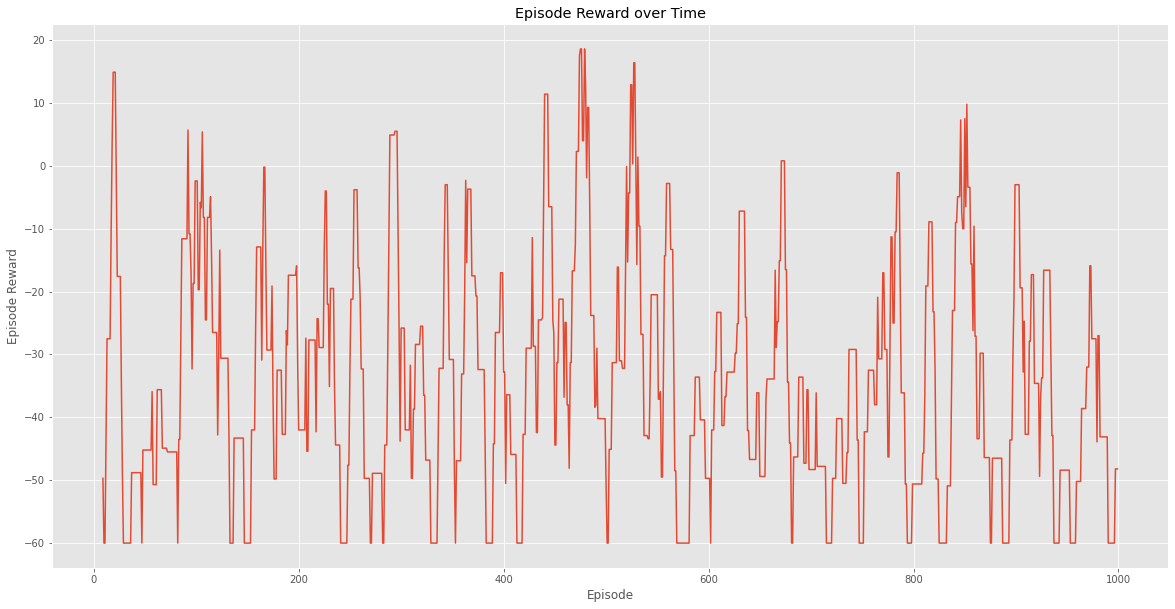

In [ ]:
plot_extrinsic_rewards(stats2)

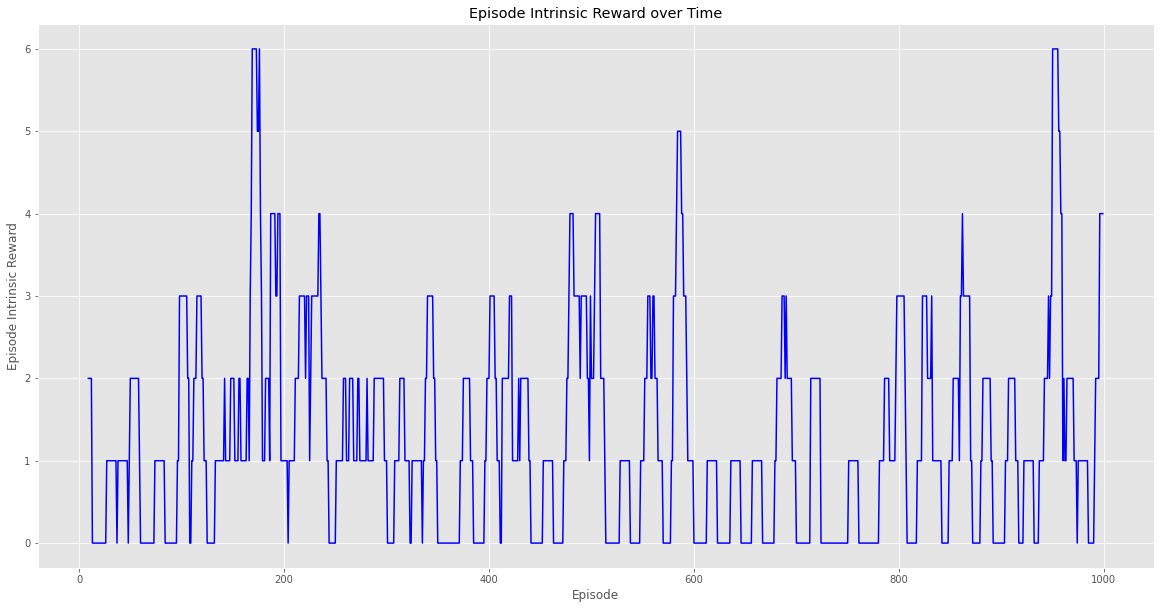

In [ ]:
plot_intrinsic_rewards(stats2)

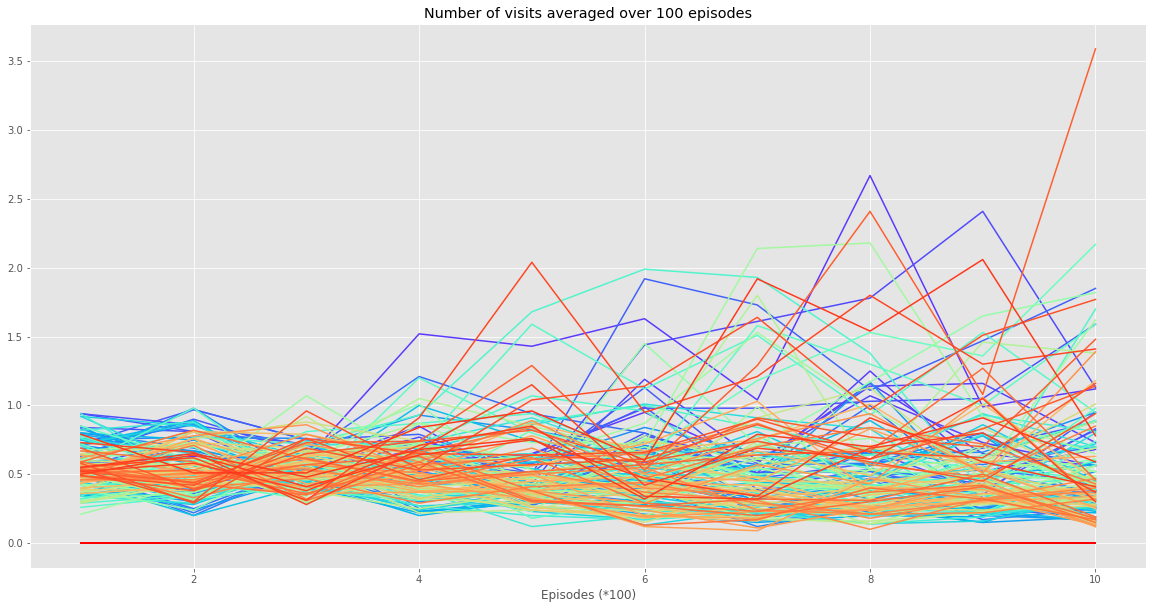

In [ ]:
plot_visited_states(visits2, NUM_EPISODES)

## CraftingWorld Environment

### Q-learning

In [ ]:
# Try factory reset runtime if having error
NUM_EPISODES = 1000
Q1, stats1, visits1, tasks1 = q_learning('CraftingWorld', NUM_EPISODES, lr=0.00025, exploration_schedule=ExplorationSchedule(50000, 0.1, 1.0))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


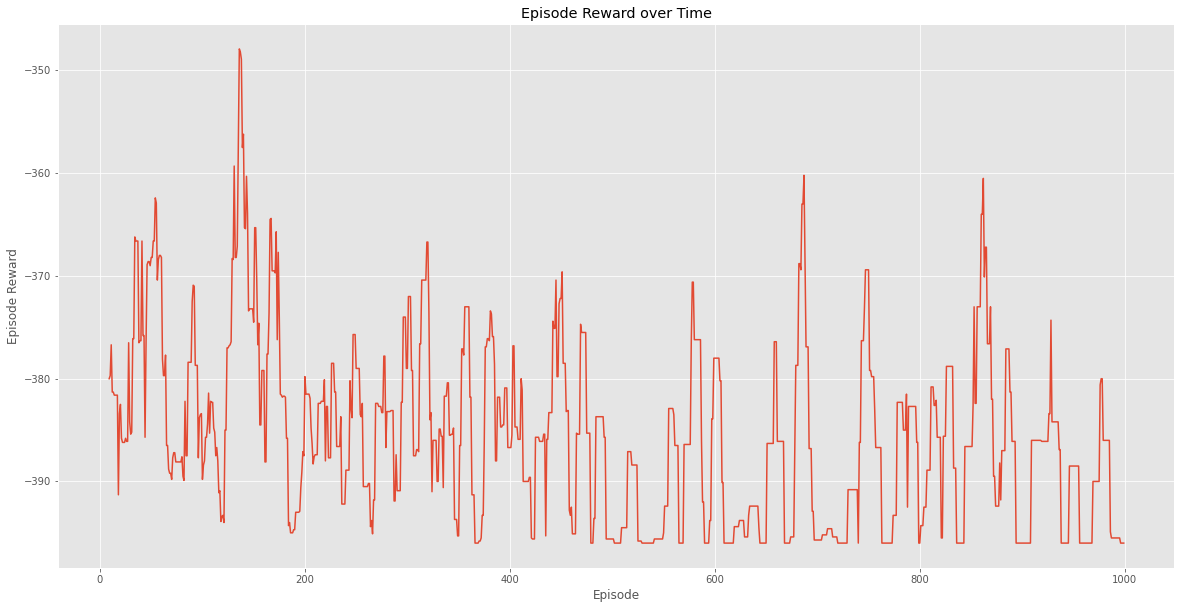

In [ ]:
plot_extrinsic_rewards(stats1) 

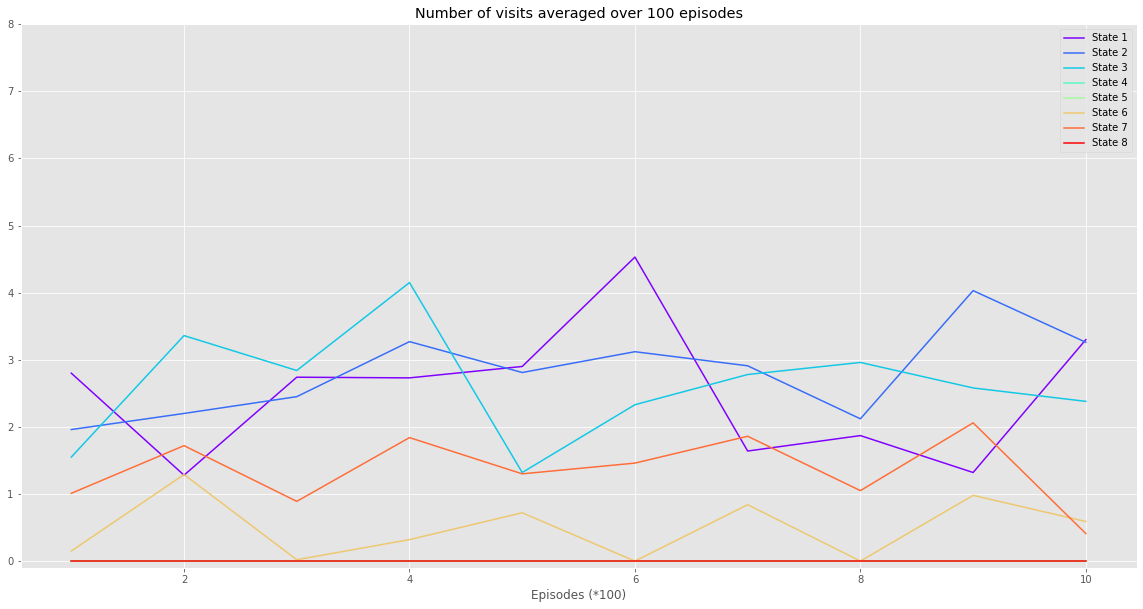

In [ ]:
plot_visited_states(visits1, NUM_EPISODES)

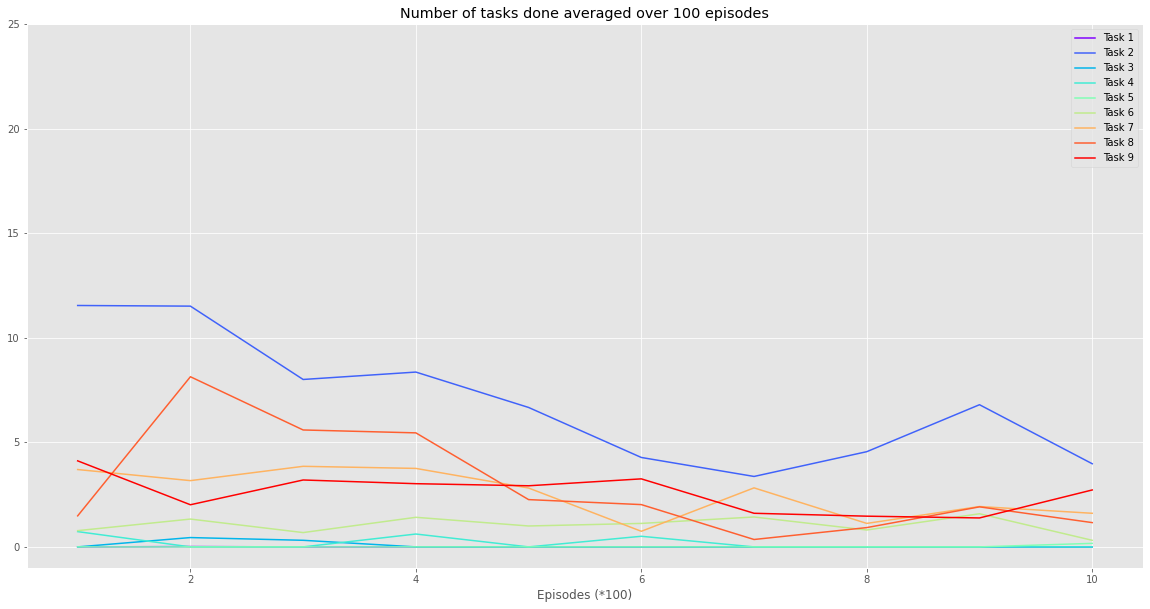

In [ ]:
plot_tasks_done(tasks1, NUM_EPISODES)

### h-DQN

In [ ]:
NUM_EPISODES = 1000
BATCH_SIZE = 16
GAMMA = 1.0
REPLAY_MEMORY_SIZE = 10000
LEARNING_RATE = 0.00025
ALPHA = 0.95
EPS = 0.01

optimizer_spec = OptimizerSpec(
  constructor=optim.RMSprop,
  kwargs=dict(lr=LEARNING_RATE, alpha=ALPHA, eps=EPS)
)

agent = hDQN(
  env_name='CraftingWorld',
  optimizer_spec=optimizer_spec,
  replay_memory_size=REPLAY_MEMORY_SIZE,
  batch_size=BATCH_SIZE
)

In [ ]:
agent, stats3, visits3, tasks3 = hdqn_learning(
  env_name='CraftingWorld',
  agent=agent,
  num_episodes=NUM_EPISODES,
  exploration_schedule=ExplorationSchedule(50000, 0.1, 1),
  gamma=GAMMA
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


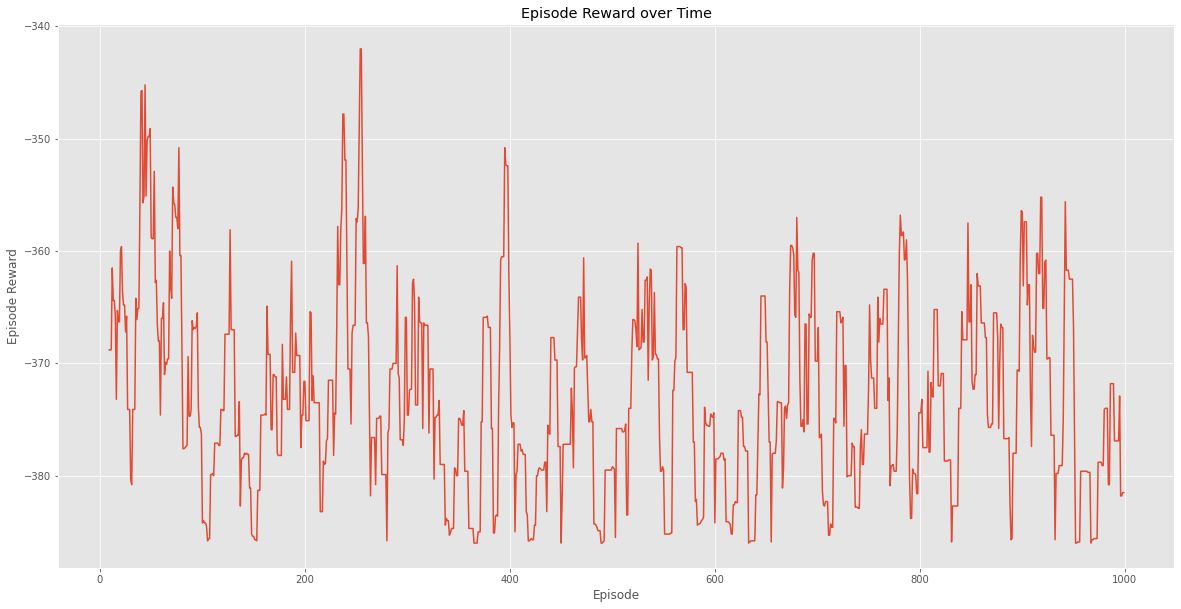

In [ ]:
plot_extrinsic_rewards(stats3) 

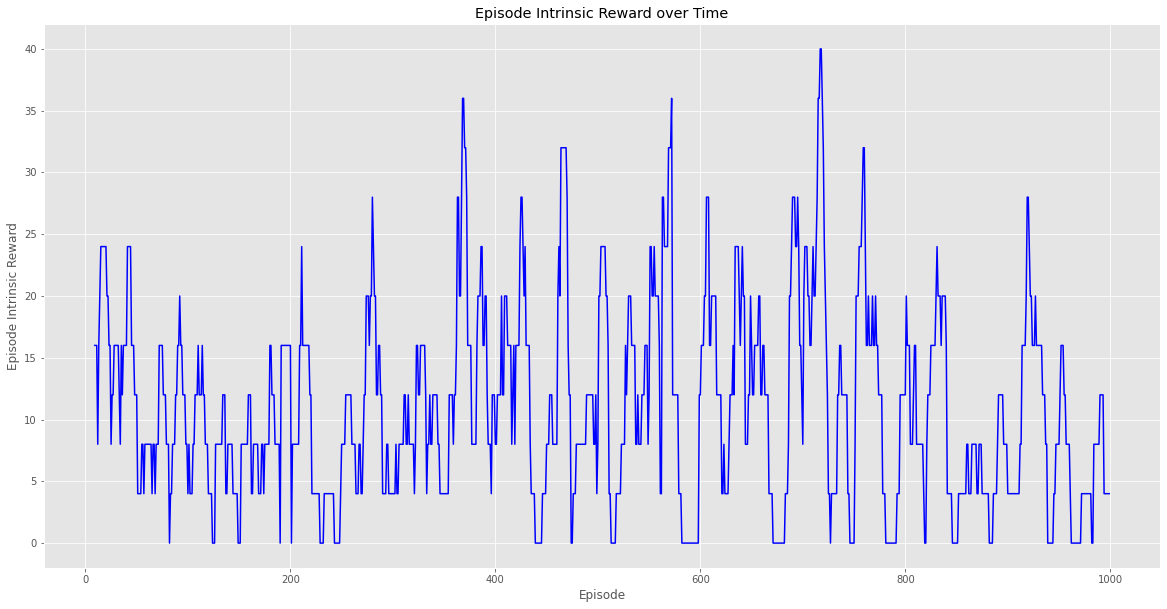

In [ ]:
plot_intrinsic_rewards(stats3) 

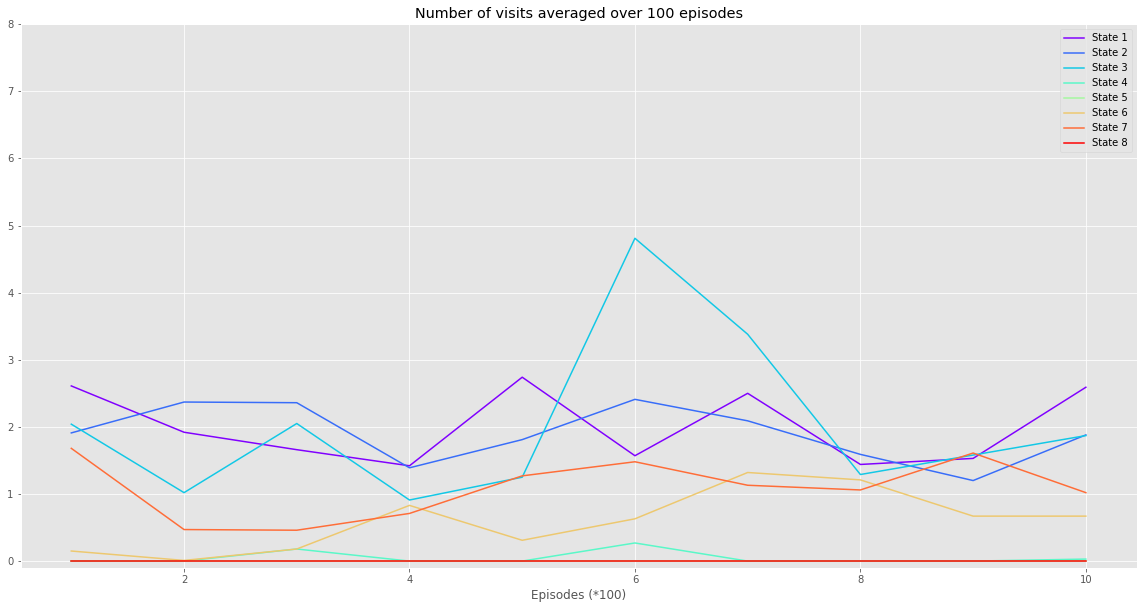

In [ ]:
plot_visited_states(visits3, NUM_EPISODES)

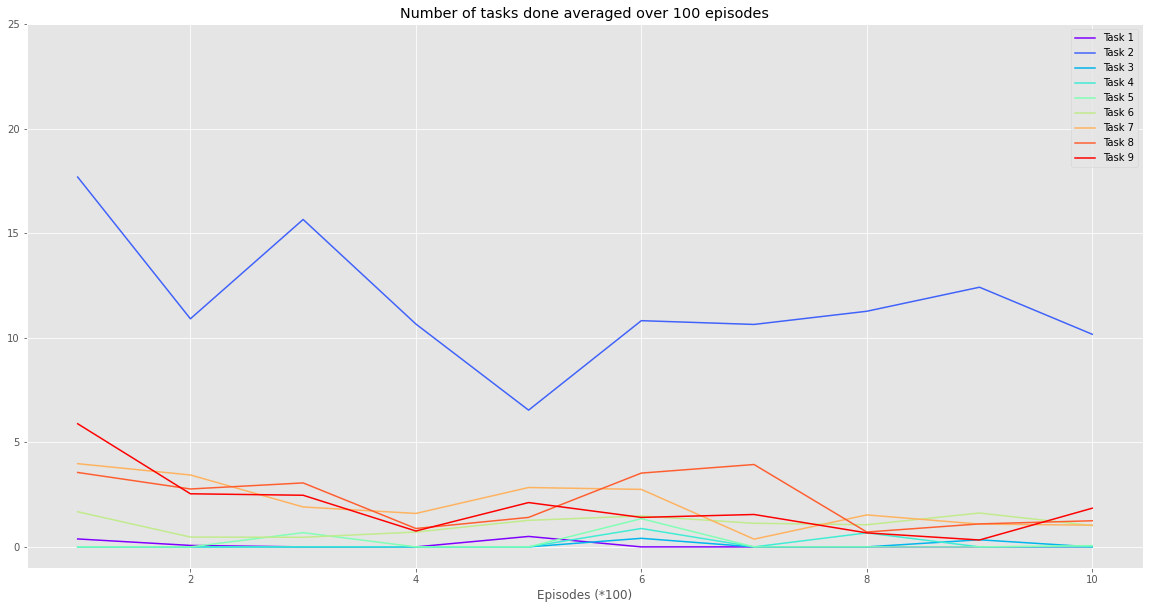

In [ ]:
plot_tasks_done(tasks3, NUM_EPISODES)